In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt

In [35]:
def plot_result(result,start_from=1,period=25,insert_index=9,time_start=-10,file_name="result",title="Event Study Coefficients with Confidence Intervals"):
    summary_table=pd.DataFrame(result.summary.tables[1].data[start_from:start_from+period],columns=result.summary.tables[1].data[0])
    new_row=[0]*len(summary_table.columns)
    # insert_index = 4
    summary_table = pd.concat([summary_table.iloc[:insert_index], pd.DataFrame([new_row],columns=summary_table.columns), summary_table.iloc[insert_index:]]).reset_index(drop=True)

    summary_table["Time"]=np.array(list(range(time_start,period+time_start+1)))
    # make each column of summary_table numeric
    summary_table=summary_table.apply(pd.to_numeric, errors='ignore')
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed

    # Plot coefficients as points
    plt.plot(summary_table['Time'], summary_table["Parameter"], 'o-', label='Coefficients', color='b')

    # Plot confidence intervals as error bars
    # plt.errorbar(summary_table['Time'], summary_table["Parameter"],
    #              yerr=[summary_table["Parameter"] - summary_table['Lower CI'],
    #                    summary_table['Upper CI'] - summary_table["Parameter"]],
    #              fmt='none', ecolor='orange', elinewidth=2, capsize=4, label='Confidence Intervals')

    plt.fill_between(summary_table['Time'], summary_table['Lower CI'], summary_table['Upper CI'], color='orange', alpha=0.3, label='Confidence Intervals')

    plt.xlabel('Time')
    # Set y-axis properties
    plt.ylim(-3, 3)  # Set the y-axis limits    
    plt.ylabel("Parameter")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig("./plots/{}.png".format(file_name),dpi=300,bbox_inches="tight",transparent=False,facecolor="white")
    plt.show()
    # return summary_table

In [36]:
df=pd.read_csv("../../data/merged/len3_ship_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)

Estimation

In [37]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
5867    0
5868    0
5869    0
5870    0
5871    0
Name: mon_1, Length: 5872, dtype: uint8

In [38]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [39]:
# change to the datetime format
df['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=26))
df=df.set_index(["id","year_month"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2339 entries, (114, Timestamp('2009-11-26 00:00:00')) to (799, Timestamp('2022-12-26 00:00:00'))
Columns: 125 entries, year to year_trend
dtypes: float64(11), int32(3), int64(93), object(6), uint8(12)
memory usage: 2.0+ MB


(125, 167, 27)

In [40]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [41]:
# formula="rx_dom ~ +elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"

# # stock lag
# # formula="rx_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+stock_rx_lag+TimeEffects+EntityEffects"

# # with month dummies
# # formula+=months

# # ytrend
# # formula+=ytrend

# # mod_fe=PanelOLS.from_formula(formula, data=df,check_rank=False,drop_absorbed=True)
# # drop_absorbed=True
# mod_fe=PanelOLS.from_formula(formula, data=df,check_rank=False,drop_absorbed=True)
# res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# # print(res_fe.summary.tables[0])
# plot_result(res_fe,file_name="rx_mon",title="rx_mon")

                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
elasped_m10    -0.2949     0.2700    -1.0920     0.2749     -0.8244      0.2346
elasped_m9     -0.3495     0.2295    -1.5228     0.1279     -0.7996      0.1006
elasped_m8     -0.2585     0.1978    -1.3066     0.1915     -0.6464      0.1295
elasped_m7     -0.4089     0.2319    -1.7634     0.0780     -0.8637      0.0458
elasped_m6     -0.3415     0.1515    -2.2540     0.0243     -0.6386     -0.0444
elasped_m5     -0.2239     0.1647    -1.3595     0.1741     -0.5468      0.0991
elasped_m4     -0.4066     0.1643    -2.4757     0.0134     -0.7288     -0.0845
elasped_m3     -0.1120     0.1296    -0.8638     0.3878     -0.3662      0.1422
elasped_m2     -0.1418     0.0758    -1.8701     0.0616     -0.2905      0.0069
elasped_0      -0.2238     0.0567    -3.

C:\Users\hakos\AppData\Local\Temp\ipykernel_9528\3043761385.py:13: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


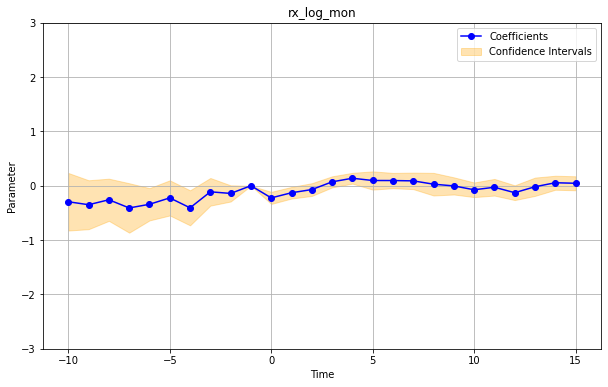

In [42]:
# take log
formula="log_rx_dom ~ elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"
# stock lag version and month dummies
# formula="log_rx_dom ~ generic_per+log_stock_rx_lag+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"

# with months
# formula+=months

# ytrend
# formula+=ytrend

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon",title="rx_log_mon")

### OTC

In [43]:

# formula="otc_dom ~ elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+generic_per+TimeEffects+EntityEffects"


# # stock lag only
# # formula+="+stock_otc_lag"

# # # with months
# # formula+=months

# # # ytrend
# # formula+=ytrend


# mod_fe=PanelOLS.from_formula(formula, data=df, drop_absorbed=True)
# res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
# plot_result(res_fe,file_name="otc_mon",title="otc_mon")

C:\Users\hakos\AppData\Local\Temp\ipykernel_9528\3789889101.py:25: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

generic_per

  res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)


                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
elasped_m10    -0.5474     0.8148    -0.6719     0.5017     -2.1453      1.0505
elasped_m9     -1.6325     1.2382    -1.3184     0.1875     -4.0608      0.7958
elasped_m8     -2.1315     1.1662    -1.8278     0.0677     -4.4185      0.1554
elasped_m7     -2.8890     1.0734    -2.6915     0.0072     -4.9940     -0.7840
elasped_m6     -1.1011     0.9736    -1.1309     0.2582     -3.0105      0.8083
elasped_m5     -2.1789     0.9468    -2.3014     0.0215     -4.0356     -0.3222
elasped_m4     -1.8950     0.5971    -3.1737     0.0015     -3.0659     -0.7240
elasped_m3     -1.1298     0.4685    -2.4113     0.0160     -2.0486     -0.2109
elasped_m2     -0.4531     0.3458    -1.3106     0.1901     -1.1312      0.2249
elasped_0      -0.6883     0.4158    -1.

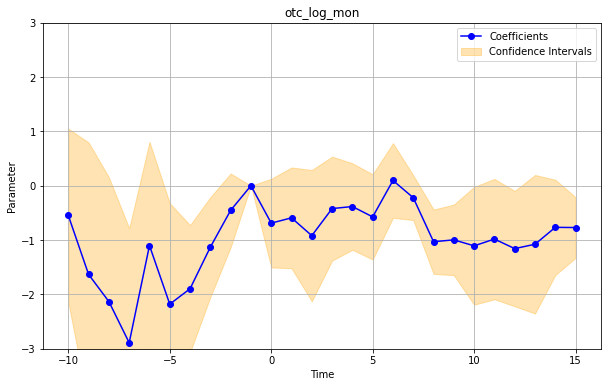

In [44]:
# take log

# till 20
# formula="log_otc_dom ~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+elasped_16+elasped_17+elasped_18+elasped_19+elasped_20+generic_per+TimeEffects+EntityEffects"

# till 15
formula="log_otc_dom ~ elasped_m10+elasped_m9+elasped_m8+elasped_m7+elasped_m6+elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15"

# gemeric_per
formula+=" + generic_per"

# fixed effects
formula+=" + EntityEffects + TimeEffects"

# add lagged stock
# formula+="+log_stock_otc_lag"

# with month dummies
# formula+=months

# ytrend
# formula+=ytrend

mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon",title="otc_log_mon")